In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from lmfit import Model, Parameters
from lmfit.models import QuadraticModel
from tqdm.notebook import tqdm

from scripts.extensional_paras import fit_poly

In [2]:
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=0.7, rc={'grid.linewidth': 0.5})

Find number of beads per condition

In [34]:
beads_all_path = "..\\data\\20230725_paa_beads\\20231120_paa_beads_all.tsv"
df_all = pd.read_csv(beads_all_path, sep='\t', index_col=0)

In [36]:
print("Number of unique beads per condition:")
flow_rates = df_all['flow_rate'].unique()
samples = df_all['sample'].unique()
dict_beads_numbers = {}
for sample in samples:
    for fr in flow_rates:
        df_samp_fr = df_all.loc[(df_all['sample'] == sample)
                                & (df_all['flow_rate'] == fr)]
        count = len(df_samp_fr['object_number'].unique())
        dict_beads_numbers[f"{sample}_{fr}"] = count
        print(f"{sample} - {fr} ul/s: {count}")

Number of unique beads per condition:
s4_17um - 0.02 ul/s: 1220
s4_17um - 0.04 ul/s: 1208
s4_17um - 0.06 ul/s: 1202
s4_17um - 0.08 ul/s: 1590
s4_17um - 0.1 ul/s: 1618
s4_18um - 0.02 ul/s: 1430
s4_18um - 0.04 ul/s: 1818
s4_18um - 0.06 ul/s: 1820
s4_18um - 0.08 ul/s: 2418
s4_18um - 0.1 ul/s: 1806
s8_15um - 0.02 ul/s: 1340
s8_15um - 0.04 ul/s: 1696
s8_15um - 0.06 ul/s: 1625
s8_15um - 0.08 ul/s: 1684
s8_15um - 0.1 ul/s: 1676


Load data

In [3]:
save_med_path = "..\\data\\20230725_paa_beads\\20240226_beads_median_data.tsv"
df_median = pd.read_csv(save_med_path, sep='\t', index_col=0)
# only use data with flow_rate > 0.02
df_median= df_median.loc[0.02 < df_median['flow_rate']]

In [4]:
time_feat = 'time_shift'
strain_feat = 'net_strain_inert_corr'
stress_feat = 'stress_net_ir'

General integral solution of the Kelvin-Voigt model

In [5]:
def fsize_cm(size_x, size_y):
    """
    
    :param size_x: Figure width in inch
    :param size_y: Figure height in inch
    :return: tuple(width, height) in cm
    """
    return size_x / 2.54, size_y / 2.54

def kv_strain_poly_stress_from_int(t, lmbda, viscosity, strain_0, stress_poly, offset=0):
    strains = []
    for tt in t:
        x = np.linspace(0, tt, 100)
        integral = np.trapz(stress_poly(x) * np.exp(lmbda*x), x=x)
        sum_part_2 = integral / viscosity
        strains.append(np.exp(-lmbda * tt) * (strain_0 + sum_part_2) + offset)
    return strains

def kv_strain_poly_stress_from_int_global_p(t, lmbda, viscosity, strain_0,
                                            offset):
    global p
    strains = []
    for tt in t:
        x = np.linspace(0, tt, 100)
        integral = np.trapz(p(x) * np.exp(lmbda*x), x=x)
        sum_part_2 = integral / viscosity
        strains.append(np.exp(-lmbda * tt) * (strain_0 + sum_part_2) + offset)
    return strains

##### Get stress functions

In [6]:
samples = df_median['sample'].unique()
flow_rates = np.sort(df_median['flow_rate'].unique())

stress_polys = {}

for sample in tqdm(samples, desc='Samples: '):
    for fr in flow_rates:
        df = df_median[df_median['sample'] == sample]
        df = df[df['flow_rate'] == fr]
        if len(df) > 0:
            x = df[time_feat].to_numpy()
            y = df[stress_feat].to_numpy()

            key = "{}_{}".format(sample, fr)
            stress_polys[key] = fit_poly(x, y, 8)

Samples:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
df_kv_fit = pd.DataFrame()
for sample in tqdm(samples, desc='Samples: '):
    for fr in flow_rates:
        df = df_median[df_median['sample'] == sample]
        df = df[df['flow_rate'] == fr]

        if len(df) > 0:
            time = df[time_feat].to_numpy()
            strain = df[strain_feat].to_numpy()
            # sort for time to get clean plot
            idx = np.argsort(time)
            time = time[idx]
            strain = strain[idx]

            # define parameters that the fit models will use
            params = Parameters()
            params.add('viscosity', value=0.5, min=0.01, max=20)
            params.add('lmbda', value=1000, min=0.1, max=20000)
            params.add('strain_0', value=0.03, min=0, max=0.1)
            params.add('offset', value=0.0, min=0, max=0.1)
            params['offset'].vary = False

            # add stress polynomial factors
            key = "{}_{}".format(sample, fr)
            p = stress_polys[key]

            # create fit model
            fmodel = Model(kv_strain_poly_stress_from_int_global_p)

            fit_result = fmodel.fit(strain, params, t=time, nan_policy='omit')
            # errors = np.sqrt(np.diag(fit_result.covar))
            df_fit_paras = pd.DataFrame()
            df_fit_paras['sample'] = [sample]
            df_fit_paras['flow_rate'] = [fr]
            fit_paras = ['viscosity', 'lmbda', 'strain_0', 'offset']
            for ii, para in enumerate(fit_paras):
                df_fit_paras[para] = [fit_result.best_values[para]]
                df_fit_paras[para + '_err'] = fit_result.params[para].stderr
            df_kv_fit = pd.concat([df_kv_fit, df_fit_paras])

df_kv_fit.reset_index(inplace=True, drop=True)

Samples:   0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
visc = df_kv_fit['viscosity']
visc_err = df_kv_fit['viscosity_err']
lmbda = df_kv_fit['lmbda']
lmbda_err = df_kv_fit['lmbda_err']
df_kv_fit['emodulus'] = visc * lmbda
df_kv_fit['emodulus_err'] = np.sqrt((visc * lmbda_err) ** 2 + (lmbda * visc_err) ** 2)
df_kv_fit['relaxation_time'] = 1 / lmbda
df_kv_fit['relaxation_time_err'] = lmbda_err / lmbda ** 2

In [9]:
df_kv_fit

sample  flow_rate  viscosity  viscosity_err        lmbda    lmbda_err  \
0   s4_17um       0.04   0.119797       0.044559  2327.605566   902.216751   
1   s4_17um       0.06   0.056632       0.004861  5714.794853   543.591980   
2   s4_17um       0.08   0.179063       0.017283  1859.805762   185.777090   
3   s4_17um       0.10   0.221893       0.017206  1602.331645   130.057520   
4   s4_18um       0.04   0.238124       0.093775  2766.407199  1159.730579   
5   s4_18um       0.06   0.447089       0.087476  1520.613668   308.373625   
6   s4_18um       0.08   0.466686       0.059167  1517.570686   200.829799   
7   s4_18um       0.10   0.538604       0.054173  1349.582954   143.969035   
8   s8_15um       0.04   1.191912       0.147138   637.691074    82.863106   
9   s8_15um       0.06   1.298922       0.105515   616.950092    54.199249   
10  s8_15um       0.08   1.273813       0.081771   651.864934    46.413181   
11  s8_15um       0.10   1.133447       0.062528   768.415140    47.345832   

    strain_0  strain_0_err  offset  offset_err    emodulus  emodulus_err  \
0   0.027137      0.005007     0.0           0  278.840224    149.796045   
1   0.033088      0.009806     0.0           0  323.641495     41.465169   
2   0.043355      0.005519     0.0           0  333.022476     46.257881   
3   0.060280      0.006321     0.0           0  355.545668     39.911780   
4   0.005200      0.004617     0.0           0  658.746954    378.896509   
5   0.013868      0.003707     0.0           0  679.849038    191.576932   
6   0.020991      0.003686     0.0           0  708.229714    129.793756   
7   0.026448      0.004170     0.0           0  726.890124    106.573767   
8   0.000015      0.001860     0.0           0  760.071445    136.229265   
9   0.011983      0.001841     0.0           0  801.370076     95.884934   
10  0.016315      0.001982     0.0           0  830.354266     79.603053   
11  0.020848      0.002094     0.0           0  870.957648     72.030523   

    relaxation_time  relaxation_time_err  
0          0.000430             0.000167  
1          0.000175             0.000017  
2          0.000538             0.000054  
3          0.000624             0.000051  
4          0.000361             0.000152  
5          0.000658             0.000133  
6          0.000659             0.000087  
7          0.000741             0.000079  
8          0.001568             0.000204  
9          0.001621             0.000142  
10         0.001534             0.000109  
11         0.001301             0.000080

##### Plot the resulting KV curves

##### Combined plot: strain, strain, fit

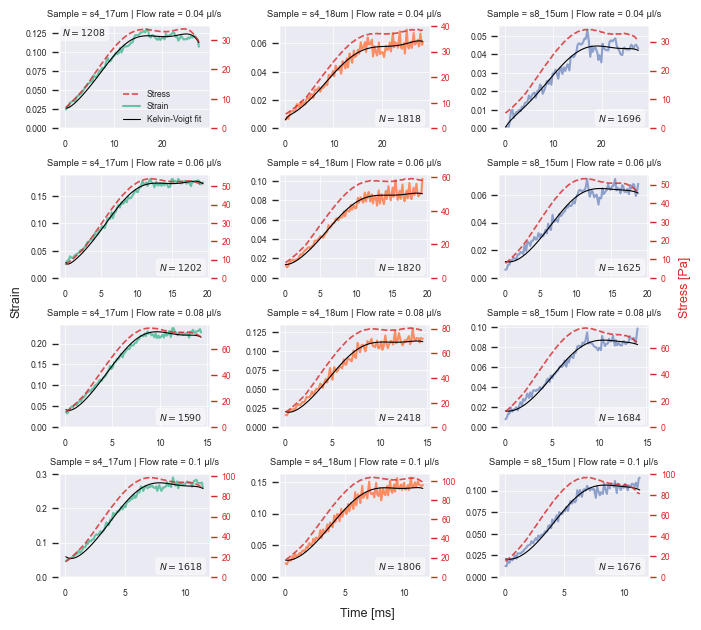

In [48]:
samples = df_median['sample'].unique()
flow_rates = np.sort(df_median['flow_rate'].unique())

fsize = fsize_cm(17, 16)
stress_color = 'tab:red'
n_cols = len(samples)
colors = sns.color_palette('Set2', n_cols)
fig, axes = plt.subplots(nrows=len(flow_rates), ncols=n_cols, figsize=fsize,
                         sharex='row')
# create array with twin axes
axes_tw = np.empty_like(axes)
for ii in range(len(flow_rates)):
    for jj in range(len(samples)):
        ax = axes[ii, jj]
        axes_tw[ii, jj] = ax.twinx()

for jj, sample in enumerate(samples):
    for ii, fr in enumerate(flow_rates):
        df = df_median[df_median['sample'] == sample]
        df = df[df['flow_rate'] == fr]

        ax = axes[ii, jj]
        ax.set_title("Sample = {} | Flow rate = {} µl/s".format(sample, fr))
        ax_tw = axes_tw[ii, jj]
        if len(df) > 0:
            t = df[time_feat].to_numpy()
            strain = df[strain_feat].to_numpy()
            ax.plot(t *1e3, strain, '-', lw=1.5, 
                    color=colors[jj], alpha=1, 
                    label="Strain")

            stress = df[stress_feat].to_numpy()
            ax_tw.plot(t *1e3, stress, '--', color=stress_color,
                       alpha=0.8, label="Stress")
            ax_tw.grid()

            # display number of beads included in the measurement
            count = dict_beads_numbers[f"{sample}_{fr}"]
            if ii == 0 and jj == 0:
                ax.text(0.02, 0.98, f"$N = {count}$",
                        ha='left', va='top', transform=ax.transAxes,
                        bbox={'facecolor': 'w', 'boxstyle': 'round', 'alpha': 0.5})
            else:
                ax.text(0.95, 0.05, f"$N = {count}$",
                        ha='right', va='bottom', transform=ax.transAxes,
                        bbox={'facecolor': 'w', 'boxstyle': 'round', 'alpha': 0.5})
            
            kv_paras = df_kv_fit.loc[(df_kv_fit['sample'] == sample)
                                     & (df_kv_fit['flow_rate'] == fr)
                                     ]
            if len(kv_paras) > 0:
                key = "{}_{}".format(sample, fr)
                p = stress_polys[key]
                y_kv = kv_strain_poly_stress_from_int(t,
                                                      kv_paras['lmbda'].iloc[0],
                                                      kv_paras['viscosity'].iloc[0],
                                                      kv_paras['strain_0'].iloc[0],
                                                      p,
                                                      offset=kv_paras['offset'].iloc[0])
                ax.plot(t *1e3, y_kv, ls='-', c='k', lw=0.8, label="Kelvin-Voigt fit")

for ii in range(len(flow_rates)):
    for jj in range(len(samples)):
        axes[ii, jj].set_ylim(0)
        axes_tw[ii, jj].set_ylim(0)
        axes_tw[ii, jj].tick_params(axis='y', colors=stress_color)

# add legend to first plot
x_legend= 0.4
axes[0, 0].legend(loc=[x_legend, 0.01], frameon=False)
axes_tw[0, 0].legend(loc=[x_legend, 0.255], frameon=False)

label_fontsize = 9
fig.supxlabel("Time [ms]", fontsize=label_fontsize,
              x=0.525, y=0.015)
# left side label
fig.text(0, 0.5, "Strain", fontsize=label_fontsize, 
         rotation=90, ha='center')
# right side label
fig.text(1, 0.5, "Stress [Pa]", fontsize=label_fontsize, 
         color=stress_color, rotation=90, ha='center')

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\SI\\fig_s4_strain_stress_time.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

Plot s4_18um at 0.04 µL/s as example

In [11]:
sample = 's4_18um'
fr = 0.04
df_s4_18um_004 = df_median.loc[(df_median['sample'] == sample) 
                               & (df_median['flow_rate'] == fr)]

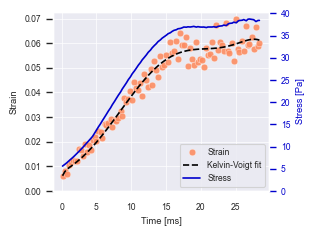

In [12]:
colors = sns.color_palette('Set2', len(samples))
stress_color = 'mediumblue'

fsize = fsize_cm(8, 6)
fig, ax = plt.subplots(1, 1, figsize=fsize)
ax_tw = ax.twinx()

# strain scatterplot
t = df_s4_18um_004[time_feat].to_numpy()
strain = df_s4_18um_004[strain_feat].to_numpy()
ax.plot(t *1e3, strain, 'o', color=colors[1], alpha=.9, label="Strain",
        markeredgewidth=0.25, markeredgecolor='w')

# stress lineplot
stress = df_s4_18um_004[stress_feat].to_numpy()
ax_tw.plot(t *1e3, stress, '-', color=stress_color,
             alpha=1, label="Stress")

# strain fit
kv_paras = df_kv_fit.loc[(df_kv_fit['sample'] == sample)
                         & (df_kv_fit['flow_rate'] == fr)
                         ]
if len(kv_paras) > 0:
    key = "{}_{}".format(sample, fr)
    p = stress_polys[key]
    y_kv = kv_strain_poly_stress_from_int(t,
                                          kv_paras['lmbda'].iloc[0],
                                          kv_paras['viscosity'].iloc[0],
                                          kv_paras['strain_0'].iloc[0],
                                          p,
                                          offset=kv_paras['offset'].iloc[0])
    ax.plot(t *1e3, y_kv, ls='--', c='k', label="Kelvin-Voigt fit")

ax_tw.grid()

ax.set_ylim(0)
ax_tw.set_ylim(0)

ax.set_xlabel("Time [ms]")
ax.set_ylabel("Strain")

ax_tw.set_ylabel("Stress [Pa]", color=stress_color)
ax_tw.tick_params(axis='y', colors=stress_color)

#build combined legend
h_strain, l_strain = ax.get_legend_handles_labels()
h_stress, l_stress = ax_tw.get_legend_handles_labels()

h_all = h_strain + h_stress
l_all = l_strain + l_stress
ax.legend(h_all, l_all, loc='lower right')

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig3_strain_stress_time.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

Plot s4_17um at 0.04 µL/s as example

In [13]:
sample = 's4_17um'
fr = 0.04
df_s4_17um_004 = df_median.loc[(df_median['sample'] == sample) 
                               & (df_median['flow_rate'] == fr)]

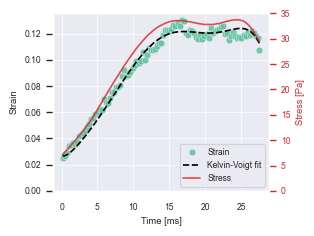

In [14]:
colors = sns.color_palette('Set2', len(samples))
stress_color = 'tab:red'

fsize = fsize_cm(8, 6)
fig, ax = plt.subplots(1, 1, figsize=fsize)
ax_tw = ax.twinx()

# strain scatterplot
t = df_s4_17um_004[time_feat].to_numpy()
strain = df_s4_17um_004[strain_feat].to_numpy()
ax.plot(t *1e3, strain, 'o', color=colors[0], alpha=.9, label="Strain",
        markeredgewidth=0.25, markeredgecolor='w')

# stress lineplot
stress = df_s4_17um_004[stress_feat].to_numpy()
ax_tw.plot(t *1e3, stress, '-', color=stress_color,
             alpha=0.8, label="Stress")

# strain fit
kv_paras = df_kv_fit.loc[(df_kv_fit['sample'] == sample)
                         & (df_kv_fit['flow_rate'] == fr)
                         ]
if len(kv_paras) > 0:
    key = "{}_{}".format(sample, fr)
    p = stress_polys[key]
    y_kv = kv_strain_poly_stress_from_int(t,
                                          kv_paras['lmbda'].iloc[0],
                                          kv_paras['viscosity'].iloc[0],
                                          kv_paras['strain_0'].iloc[0],
                                          p,
                                          offset=kv_paras['offset'].iloc[0])
    ax.plot(t *1e3, y_kv, ls='--', c='k', label="Kelvin-Voigt fit")

ax_tw.grid()

ax.set_ylim(0)
ax_tw.set_ylim(0)

ax.set_xlabel("Time [ms]")
ax.set_ylabel("Strain")

ax_tw.set_ylabel("Stress [Pa]", color=stress_color)
ax_tw.tick_params(axis='y', colors=stress_color)

#build combined legend
h_strain, l_strain = ax.get_legend_handles_labels()
h_stress, l_stress = ax_tw.get_legend_handles_labels()

h_all = h_strain + h_stress
l_all = l_strain + l_stress
ax.legend(h_all, l_all, loc='lower right')

plt.tight_layout()
plt.show()

# save_path = "..\\figure_plots\\fig3_strain_stress_time.pdf"
# fig.savefig(save_path, format='pdf', dpi=900,
#             bbox_inches='tight', pad_inches=fsize[0] / 50
#             )

## Plot resulting KV values over flow rate
#### Young's modulus

In [15]:
emods = {'s4_17um': 379,
         's4_17um_err': 17,
         's4_18um': 669,
         's4_18um_err': 32,
         's8_15um': 832,
         's8_15um_err': 15
         }

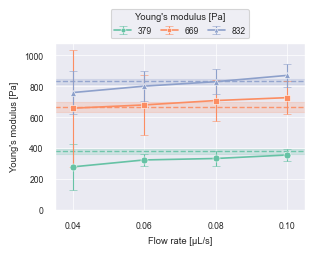

In [27]:
feat = 'emodulus'
x_feat = 'flow_rate'

samples = ['s4_17um', 's4_18um', 's8_15um']
colors = sns.color_palette('Set2', len(samples))
markers = ['o', 's', '^']

fsize = fsize_cm(8, 6.5)
fig, ax = plt.subplots(1, 1, figsize=fsize)
for ii, sample in enumerate(samples):
    df_no_offset = df_kv_fit.loc[df_kv_fit['sample'] == sample]

    x = df_no_offset[x_feat].to_numpy()
    value = df_no_offset[feat].to_numpy()
    error = df_no_offset[feat + "_err"].to_numpy()
    ax.errorbar(x, value, yerr=error, 
                c=colors[ii], alpha=1, capsize=3, elinewidth=0.8,
                marker=markers[ii], ms=5, mec='w', mew=0.4,
                label=sample
                )
    # plot mean and error margin of measured value
    emod = emods[sample]
    emod_err = emods[sample + '_err']
    ax.fill_between([0.01, 0.11],
                    [emod + emod_err, emod + emod_err], [emod - emod_err, emod - emod_err],
                    color=colors[ii], alpha=.2
                    )
    ax.axhline(emod, color=colors[ii], ls='--', lw=1, zorder=1, alpha=.9)

    ax.set_xlim(0.035, 0.105)

ax.set_ylim(0)
ax.set_xticks([0.04, 0.06, 0.08, 0.1])

# axes[0].legend(loc='upper right', fontsize=14)

ax.set_xlabel("Flow rate [µL/s]")
ax.set_ylabel(r"Young's modulus [Pa]")

# create handle for expected YM lines
ax.plot([0], [0], c='gray', ls='--', lw=1, 
        # label="YM theory"
        )

handles, labels = ax.get_legend_handles_labels()
# handles = handles[1:] + [handles[0]]
# labels = labels[1:] + [labels[0]]
labels = ["379", "669", "832"]
ax.legend(handles, labels, loc='lower center', bbox_to_anchor=[0.5, 1], 
          title="Young's modulus [Pa]",
          markerscale=0.7,
          ncol=4, columnspacing=1.0, handletextpad=0.8)

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig3_emodulus.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

#### Relaxation time

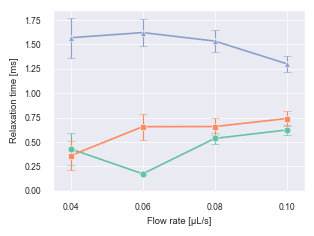

In [28]:
feat = 'relaxation_time'
x_feat = 'flow_rate'

samples = ['s4_17um', 's4_18um', 's8_15um']
colors = sns.color_palette('Set2', len(samples))
markers = ['o', 's', '^']

fsize = fsize_cm(8, 6)
fig, ax = plt.subplots(1, 1, figsize=fsize)
for ii, sample in enumerate(samples):
    df_no_offset = df_kv_fit.loc[df_kv_fit['sample'] == sample]

    x = df_no_offset[x_feat].to_numpy()
    value = df_no_offset[feat].to_numpy() * 1000
    error = df_no_offset[feat + "_err"].to_numpy() * 1000
    ax.errorbar(x, value, yerr=error,
                c=colors[ii], alpha=1, capsize=3, elinewidth=0.8,
                marker=markers[ii], ms=5, mec='w', mew=0.4,
                label=sample
                )
    ax.set_xlim(0.035, 0.105)

ax.set_ylim(0)
ax.set_xticks([0.04, 0.06, 0.08, 0.1])

# axes[0].legend(loc='upper right', fontsize=14)

ax.set_xlabel("Flow rate [µL/s]")
ax.set_ylabel(r"Relaxation time [ms]")

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig3_relaxation_time.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

#### Viscosity

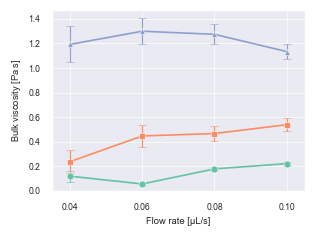

In [29]:
feat = 'viscosity'
x_feat = 'flow_rate'

samples = ['s4_17um', 's4_18um', 's8_15um']
colors = sns.color_palette('Set2', len(samples))
markers = ['o', 's', '^']

fsize = fsize_cm(8, 6)
fig, ax = plt.subplots(1, 1, figsize=fsize)
for ii, sample in enumerate(samples):
    df_no_offset = df_kv_fit.loc[df_kv_fit['sample'] == sample]

    x = df_no_offset[x_feat].to_numpy()
    value = df_no_offset[feat].to_numpy()
    error = df_no_offset[feat + "_err"].to_numpy()
    ax.errorbar(x, value, yerr=error,
                c=colors[ii], alpha=1, capsize=3, elinewidth=0.8,
                marker=markers[ii], ms=5, mec='w', mew=0.4,
                label=sample
                )
    ax.set_xlim(0.035, 0.105)

ax.set_ylim(0)
ax.set_xticks([0.04, 0.06, 0.08, 0.1])

# axes[0].legend(loc='upper right', fontsize=14)

ax.set_xlabel("Flow rate [µL/s]")
ax.set_ylabel(r"Bulk viscosity [Pa$\,$s]")

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig3_viscosity.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

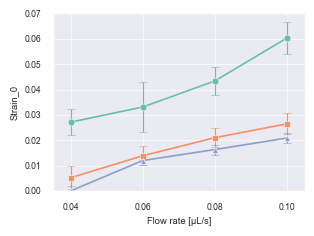

In [31]:
feat = 'strain_0'
x_feat = 'flow_rate'

samples = ['s4_17um', 's4_18um', 's8_15um']
colors = sns.color_palette('Set2', len(samples))
markers = ['o', 's', '^']

fsize = fsize_cm(8, 6)
fig, ax = plt.subplots(1, 1, figsize=fsize)
for ii, sample in enumerate(samples):
    df_no_offset = df_kv_fit.loc[df_kv_fit['sample'] == sample]

    x = df_no_offset[x_feat].to_numpy()
    value = df_no_offset[feat].to_numpy()
    error = df_no_offset[feat + "_err"].to_numpy()
    ax.errorbar(x, value, yerr=error,
                c=colors[ii], alpha=1, capsize=3, elinewidth=0.8,
                marker=markers[ii], ms=5, mec='w', mew=0.4,
                label=sample
                )
    ax.set_xlim(0.035, 0.105)

ax.set_ylim(0)
ax.set_xticks([0.04, 0.06, 0.08, 0.1])

# axes[0].legend(loc='upper right', fontsize=14)

ax.set_xlabel("Flow rate [µL/s]")
ax.set_ylabel(r"Strain_0")

plt.tight_layout()
plt.show()

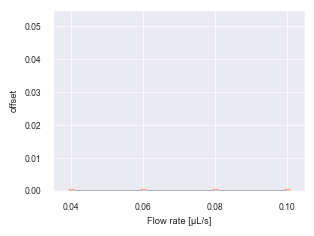

In [32]:
feat = 'offset'
x_feat = 'flow_rate'

samples = ['s4_17um', 's4_18um', 's8_15um']
colors = sns.color_palette('Set2', len(samples))
markers = ['o', 's', '^']

fsize = fsize_cm(8, 6)
fig, ax = plt.subplots(1, 1, figsize=fsize)
for ii, sample in enumerate(samples):
    df_no_offset = df_kv_fit.loc[df_kv_fit['sample'] == sample]

    x = df_no_offset[x_feat].to_numpy()
    value = df_no_offset[feat].to_numpy()
    error = df_no_offset[feat + "_err"].to_numpy()
    ax.errorbar(x, value, yerr=error,
                c=colors[ii], alpha=1, capsize=3, elinewidth=0.8,
                marker=markers[ii], ms=5, mec='w', mew=0.4,
                label=sample
                )
    ax.set_xlim(0.035, 0.105)

ax.set_ylim(0)
ax.set_xticks([0.04, 0.06, 0.08, 0.1])

# axes[0].legend(loc='upper right', fontsize=14)

ax.set_xlabel("Flow rate [µL/s]")
ax.set_ylabel(r"offset")

plt.tight_layout()
plt.show()

### Plot strain correction curves

In [19]:
save_path = os.path.join("..", "data", 
                         "20230809_Felix_optical_distortions_paa_beads", 
                         "20230809_Felix_optical_distortions_paa_beads.tsv")
df_inlet = pd.read_csv(save_path, sep='\t')

##### Filter the data

In [20]:
filter_idx = ((df_inlet['flow_rate'] == 0.01) 
              & (df_inlet['area_ratio'] < 1.05)
              # exclude this sample because it is not introduced in the text  
              & (df_inlet['sample'] != 's1_set4'))
df_filter = df_inlet.loc[filter_idx]
df_filter['sample'].replace('S8_15um', 's8_15um', inplace=True)
df_filter['net_strain_inert'] = ((df_filter['inert_ratio_raw'] - 1) 
                                 / np.sqrt(df_filter['inert_ratio_raw']))

C:\Users\freiche\AppData\Local\Temp\ipykernel_15992\1919737397.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['sample'].replace('S8_15um', 's8_15um', inplace=True)
C:\Users\freiche\AppData\Local\Temp\ipykernel_15992\1919737397.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['net_strain_inert'] = ((df_filter['inert_ratio_raw'] - 1)


##### Cut data into bins

In [21]:
df_median_inlet = pd.DataFrame()

bins = pd.cut(df_filter['pos_x'], 200)
df_grouped = df_filter.groupby(by=['sample', 'flow_rate', bins],
                               as_index=False
                               )
df_median_inlet = pd.concat([df_median_inlet, df_grouped.median()])
df_median_inlet.reset_index(inplace=True, drop=True)

roi_size_x = 680  # um
df_median_inlet['pos_x_center'] = df_median_inlet['pos_x'] - roi_size_x / 2

C:\Users\freiche\AppData\Local\Temp\ipykernel_15992\46310697.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_filter.groupby(by=['sample', 'flow_rate', bins],


##### Fit all datapoints

In [22]:
poly_degree = 2

x = df_median_inlet['pos_x_center'].to_numpy()
y = df_median_inlet['net_strain_inert'].to_numpy()

# remove nans
non_nan = ~(np.isnan(x) | np.isnan(y))
x_nonan = x[non_nan]
y_nonan = y[non_nan]

model = QuadraticModel()
# use built-in default values for paras from lmfit
paras = model.guess(y_nonan, x=x_nonan)
fit_result = model.fit(y_nonan, paras, x=x_nonan)
y_fit = model.eval(fit_result.params, x=x)

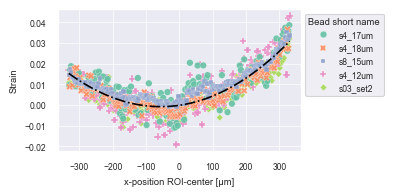

In [23]:
fsize = fsize_cm(10, 5)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.scatterplot(data=df_median_inlet,
                x='pos_x_center', y='net_strain_inert',
                hue='sample', palette='Set2',
                hue_order=['s4_17um', 's4_18um', 's8_15um', 's4_12um', 's03_set2'],
                style='sample',
                style_order=['s4_17um', 's4_18um', 's8_15um', 's4_12um', 's03_set2'],
                alpha=.9, linewidth=0.2, 
                ax=ax)
idx_plot = np.argsort(x)
x_plot = x[idx_plot]
y_plot = y_fit[idx_plot]
ax.plot(x_plot, y_plot, c='k', ls='-.')

ax.set_xlabel("x-position ROI-center [µm]")
ax.set_ylabel("Strain")
ax.legend(title="Bead short name", loc='upper left', bbox_to_anchor=[1,1])

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\SI\\fig_s4_strain_correction.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

In [24]:
fit_result.params

Parameters([('a', <Parameter 'a', value=2.111187498959283e-07 +/- 4.37e-09, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=2.3579112345984582e-05 +/- 7.51e-07, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=-0.00010309380360627034 +/- 0.000216, bounds=[-inf:inf]>)])

In [25]:
print("a = ", fit_result.params['a'].value)
print("b = ", fit_result.params['b'].value)
print("c = ", fit_result.params['c'].value)

a =  2.111187498959283e-07
b =  2.3579112345984582e-05
c =  -0.00010309380360627034
